# Create Map for Project Cover
Author: Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

plt.rcParams['savefig.facecolor'] = 'white'

In [2]:
ls ../data

FimaNfipClaims.parquet
download-data.ipynb
nfip_financial-losses-by-state_20240331.xlsx
nfip_policy-and-loss-statistics-by-flood-zone_20240331.xlsx


In [3]:
# create a DuckDB database instance
con = duckdb.connect(config={"allow_unsigned_extensions": "true"})

# assign the path of the httpfs extension. Note: I built the extension from source but you
# should review the extensions guide on DuckDB's official documentation.
path = "../duckdb/build/release/repository/v0.10.0/osx_amd64/httpfs.duckdb_extension"

# install and load extension
con.install_extension(path)

In [4]:
# create table of the claims dataset
con.sql(
    """
    CREATE TABLE claims AS
    FROM read_parquet('../data/FimaNfipClaims.parquet')
    """
)

# examine count of rows
con.sql("SELECT COUNT(*) AS count_rows FROM claims").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│    2609973 │
└────────────┘



In [5]:
hurricane_ida = con.sql(
    """
    SELECT
        state,
        countyCode,
        SUM(amountPaidOnBuildingClaim)
        + SUM(amountPaidOnContentsClaim)
        + SUM(amountPaidOnIncreasedCostOfComplianceClaim)::INT64 AS TotalClaim
    FROM claims
    WHERE floodEvent = 'Hurricane Ida'
        AND state in ('NY', 'NJ', 'CT', 'PA')
        AND countyCode NOT NULL
    GROUP BY 1, 2    
    """
)

con.sql('SELECT COUNT(*) FROM hurricane_ida')

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│           78 │
└──────────────┘

In [6]:
df = hurricane_ida.df()

print(df.shape)
df.head()

(78, 3)


,state,countyCode,TotalClaim
0,CT,09013,10267.68
1,PA,42013,547121.48
2,PA,42101,17439319.11
3,PA,42045,2812003.68
4,NY,36047,5558563.86


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state       78 non-null     object 
 1   countyCode  78 non-null     object 
 2   TotalClaim  75 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.0+ KB


In [8]:
df = df.loc[df['TotalClaim'].notnull()].reset_index(drop=True)

df

,state,countyCode,TotalClaim
0,CT,09013,10267.68
1,PA,42013,547121.48
2,PA,42101,17439319.11
3,PA,42045,2812003.68
4,NY,36047,5558563.86
...,...,...,...
70,NY,36081,11495244.83
71,NY,36105,17732.77
72,NJ,34017,13167725.82
73,NJ,34027,4434806.17


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state       75 non-null     object 
 1   countyCode  75 non-null     object 
 2   TotalClaim  75 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.9+ KB


In [10]:
path = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'
state_gdf = gpd.read_file(path)

print(state_gdf.crs)
state_gdf.head()

epsg:4269


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [11]:
path = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip'
county_gdf = gpd.read_file(path)

print(county_gdf.crs)
county_gdf.head()

epsg:4269


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


In [12]:
county_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   3233 non-null   object  
 1   COUNTYFP  3233 non-null   object  
 2   COUNTYNS  3233 non-null   object  
 3   AFFGEOID  3233 non-null   object  
 4   GEOID     3233 non-null   object  
 5   NAME      3233 non-null   object  
 6   LSAD      3233 non-null   object  
 7   ALAND     3233 non-null   int64   
 8   AWATER    3233 non-null   int64   
 9   geometry  3233 non-null   geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 252.7+ KB


In [13]:
merged_gdf = county_gdf.merge(
    df,
    left_on='GEOID',
    right_on='countyCode'
)

merged_gdf['TotalClaimNormalizedArea'] = merged_gdf['TotalClaim'] / (merged_gdf['ALAND'] / 27_878_400)

print(merged_gdf.shape)
merged_gdf.head()

(75, 14)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,state,countyCode,TotalClaim,TotalClaimNormalizedArea
0,09,009,00212798,0500000US09009,09009,New Haven,06,1565688367,667081242,"MULTIPOLYGON (((-72.76143 41.24233, -72.75973 ...",CT,09009,1874729.14,3.338113e+04
1,34,003,00882271,0500000US34003,34003,Bergen,06,602910975,35355101,"POLYGON ((-74.27066 41.02103, -74.25046 41.060...",NJ,34003,77434430.38,3.580542e+06
2,34,007,00882273,0500000US34007,34007,Camden,06,573295201,15719274,"POLYGON ((-75.13730 39.88997, -75.13541 39.893...",NJ,34007,17556.46,8.537417e+02
3,34,013,00882276,0500000US34013,34013,Essex,06,326557460,8638172,"POLYGON ((-74.37623 40.76275, -74.37389 40.762...",NJ,34013,45312322.73,3.868339e+06
4,34,023,00882230,0500000US34023,34023,Middlesex,06,800871212,35459038,"POLYGON ((-74.63023 40.34313, -74.63047 40.344...",NJ,34023,37572149.20,1.307890e+06


In [14]:
(merged_gdf
 .sort_values(by='TotalClaimNormalizedArea', ascending=False)
 .loc[:, ['NAME', 'state', 'TotalClaimNormalizedArea', 'TotalClaim']]
 .head(10)
)

,NAME,state,TotalClaimNormalizedArea,TotalClaim
64,Union,NJ,5.902543e+06,5.635269e+07
3,Essex,NJ,3.868339e+06,4.531232e+07
1,Bergen,NJ,3.580542e+06,7.743443e+07
68,Hudson,NJ,3.068532e+06,1.316773e+07
19,Westchester,NY,2.591443e+06,1.036605e+08
16,Somerset,NJ,2.400757e+06,6.732636e+07
67,Bronx,NY,1.461956e+06,5.711236e+06
39,Passaic,NJ,1.413098e+06,2.441979e+07
35,Philadelphia,PA,1.398431e+06,1.743932e+07
4,Middlesex,NJ,1.307890e+06,3.757215e+07


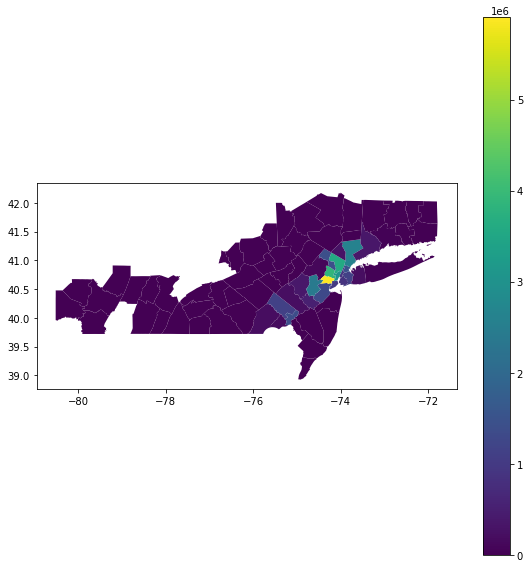

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

merged_gdf.plot(
    ax=ax,
    column='TotalClaimNormalizedArea',
    legend=True
)

plt.tight_layout()

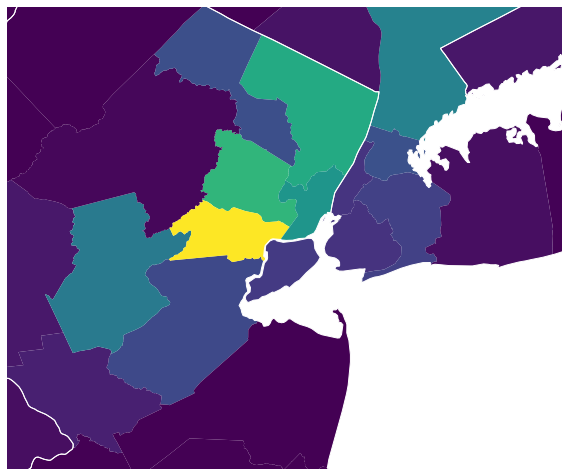

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

merged_gdf.plot(
    ax=ax,
    column='TotalClaimNormalizedArea',
)

state_gdf.plot(ax=ax, facecolor='None', edgecolor='white')

ax.set_ylim(40.1, 41.2)
ax.set_xlim(-74.9,-73.4)
plt.axis('off')

plt.tight_layout()
plt.savefig('hurricane-ida.png', dpi=250, bbox_inches='tight')